## Table of Contents
- <a href='#1'>1. Working with time in Python</a>
    - <a href='#1.1'>1.1 Dates & Times</a>
    - <a href='#1.2'>1.2 Reading and working with time-based data</a>
    - <a href='#1.3'>1.3 Resampling</a>
    - <a href='#1.4'>1.4 Moving window functions</a>
    - <a href='#1.5'>1.5 Time series decomposition</a>
- <a href='#2'>2. Statistical Model for Time Series</a>
    - <a href='#2.1'>2.1 Ordinary Linear Regression</a>
    - <a href='#2.2'>2.2 Autocorrelation</a>
    - <a href='#2.3'>2.3 ADF</a>
    - <a href='#2.4'>2.4 MR Model</a>
    - <a href='#2.5'>2.5 AR Model</a>
- <a href='#3'>3. Machine learning with time series</a>
    - <a href='#3.1'>3.1 Feature Generation</a>

## References
1. [Practical Times Series Analysis](https://github.com/PracticalTimeSeriesAnalysis/BookRepo) by Aileen Nielsen
2. [Time Series Analysis with Python Intermediate | SciPy 2016 Tutorial](https://www.youtube.com/watch?v=JNfxr4BQrLk) by Aileen Nielsen
3. [Kaggle](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series/data?)
4. [Jason Brownlee](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

In [16]:
# Import library
%matplotlib inline 
import matplotlib.pylab
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from sklearn.metrics import mean_absolute_error, mean_squared_error

# <a id='1'>1. Working with time in Python</a>
## <a id='1.1'>1.1 Dates & Times</a>
[Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

In [ ]:
# Generate series of times
rng = pd.date_range(end='2020 Jul 25', periods=29, freq = '-8H', normalize=True)
type(rng[0])                        # pandas._libs.tslibs.timestamps.Timestamp


# Timestamp
t = pd.Timestamp('7/21/2016')       # Timestamp('2016-07-10 20:00:00')
t.quarter                           
t.dayofweek  


# Timespan
p = pd.Period('7/2016')             # Period('2016-07', 'M')
p.start_time < t and p.end_time > t # timestamp falls within a given period
rng_period = pd.period_range('2016-01-01 12:15', freq = 'H', periods = 10)


# Timedelta
delta_h = pd.Timedelta('1.5 hours')
t + delta_h                         # Timestamp('2016-07-21 01:30:00')
rng + pd.Timedelta('1day')          # Addition works for range too


# Index a time series with a date_range
ts_dt = pd.Series(range(40), pd.date_range('2016-07-01 11:15', freq = '60T', periods=40))  # DateTimeindex
type(ts_dt.index)                   # pandas.core.indexes.datetimes.DatetimeIndex
type(ts_dt.index[0])                # pandas._libs.tslibs.timestamps.Timestamp
ts_pd = ts_dt.to_period(freq='60T') # PeriodIndex (no seconds in PeriodIndex)


# pd.Timestamp with a European style formatted date string
dt_eur = pd.to_datetime('4/3/2016', dayfirst = True)
dt_eur_str = dt_eur.strftime(format='%Y')             # Convert to string

## <a id='1.2'>1.2 Reading and working with time-based data</a>

In [36]:
data = pd.read_fwf('data/ao_monthly.txt', header = None,
                   index_col = 0, parse_dates = [[0, 1]],
                   infer_datetime_format = True)
data.index.names = ['Month']
data.columns = ['Value']

print(min(data.index))
print(max(data.index))


# Convert to complementary representation
data.to_period()


# Truncating
ts = pd.Series(range(10), index = pd.date_range('7/31/15', freq = 'M', periods = 10))
ts.truncate(before = '10/31/2015', after = '12/31/2015')
ts[[1, 6, 7]].index
ts[0:10:2]

## <a id='1.3'>1.3 Resampling</a>

In [38]:
# Convert into more frequent. - Forward fill
# method : {‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, None}
rng = pd.date_range('1/1/2011', periods = 72, freq = 'H')
ts = pd.Series(list(range(len(rng))), index = rng)
converted = ts.asfreq('45Min', method = 'ffill')


# .resample is more flexible. It is almost equivalent to groupby
ts.resample('2H').mean()[1:10]


# Downsample without using ffill or bfill
irreg_ts = ts[list(np.random.choice(a=list(range(len(ts))), size=10, replace=False))]
irreg_ts = irreg_ts.sort_index()

irreg_ts.resample('H').fillna(method='ffill', limit=5)
irreg_ts.resample('H').count()


## <a id='1.4'>1.4 Moving Window Functions</a>

The special thing about time series is that data points relate to one another... They are not independent
So we can to compare them and relate them. One way to do this is to look at how they change.
For example, we can 'difference' a time series

Window functions are like aggregation functions.

You can use them in conjunction with .resample() which will soon be a deferred operation

### Expanding windows
Yields the value of the statistic with all the data available up to that point in time

In [ ]:
# Shifting time
ts = pd.Series(np.random.randn(20), pd.date_range('7/1/16', freq='H', periods=20))
ts_lagged = ts.shift(5)


# Rolling function
# r.agg, r.apply, r.count, r.exclusions, r.max, r.median, r.name, r.quantile, 
# r.kurt, r.cov, r.corr, r.aggregate, r.std, r.skew, r.sum, r.var
df = pd.DataFrame(np.random.randn(600, 3), 
                  index = pd.date_range('5/1/2016', freq = 'S', periods = 600), 
                  columns = ['A', 'B', 'C'])
r = df.rolling(window = 20)
r['A'].agg(['sum', 'var'])
df.rolling(window=10, center=False).apply(lambda x: x[1]/x[2])


# Generate a rolling window function of monthly data from daily data
ts_long = pd.Series(np.random.randn(200), pd.date_range('7/1/16', freq='D', periods=200))
ts_long.resample('M').mean().rolling(window=3).mean().plot()


# Expanding window
df.expanding(min_periods = 1).mean()


# Exponentially weighted
ts = pd.Series(np.random.randn(1000), index=pd.date_range(start='1/1/16', freq='D', periods=1000))
ts.ewm(span=60, min_periods=0, adjust=True).mean().plot()
ts.rolling(window=60).mean().plot()

## <a id='1.5'>1.5 Time Series Decomposition</a>

When visualizing time series data, you should look out for some distinguishable patterns:

  * seasonality: does the data display a clear periodic pattern?
  * trend: does the data follow a consistent upwards or downward slope?
  * noise: are there any outlier points or missing values that are not consistent with the rest of the data?

You can rely on a method known as time-series decomposition to automatically extract and quantify the structure of time-series data. The statsmodels library provides the seasonal_decompose() function to perform time series decomposition out of the box.

* decomposition = sm.tsa.seasonal_decompose(time_series)

You can extract a specific component, for example seasonality, by accessing the seasonal attribute of the decomposition object.

* seasonal = decomposition.seasonal
* observed = decomposition.observed
* trend = decomposition.trend
* residuals = decomposition.resid

In [ ]:
# Import statsmodels.api as sm
import statsmodels.api as sm

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(co2_levels)

# Print the seasonality component
print(decomposition.seasonal)

# <a id='2'>2. Statistical Model for Time Series</a>
## <a id='2.1'>2.1 Ordinary Linear Regression</a>

In [ ]:
# In statsmodels:
import statsmodels.api as sm
# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(x, columns=['x'])
dfx1 = sm.add_constant(dfx)  # Add a constant to the DataFrame dfx
sm.OLS(y, dfx1).fit()

# In numpy:
np.polyfit(x, y, deg=1)

# In pandas:
pd.ols(y, x)

# In scipy:
from scipy import stats
stats.Linregress(x, y)

## <a id='2.2'>2.2 Autocorrelation</a>

* Mean Reversion - Negative autocorrelation
* Momentum, or Trend Following - Positive autocorrelation

Two diagnostic plots can be used to help choose the p and q parameters of the ARMA or ARIMA. They are:
* Autocorrelation Function (ACF). The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
* Partial Autocorrelation Function (PACF). The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations. Contrary to autocorrelation, partial autocorrelation removes the effect of previous time points

Both plots are drawn as bar charts showing the 95% and 99% confidence intervals as horizontal lines. Bars that cross these confidence intervals are therefore more significant and worth noting. Some useful patterns you may observe on these plots are:
* The model is AR if the ACF trails off after a lag and has a hard cut-off in the PACF after a lag. This lag is taken as the value for p.
* The model is MA if the PACF trails off after a lag and has a hard cut-off in the ACF after the lag. This lag value is taken as the value for q.
* ThemodelisamixofARandMAifboththeACFandPACFtrailoff.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, acf
plot_acf(x, lags=20, alpha=0.05)
print(acf(x))

## <a id='2.3'>2.3 ADF</a>
### Statistical test for random walk
* From Datacamp
* Regression test for random walk
 <br> $P_{t}$ = α + β $P_{t-1}$ + $ε_{t}$
 * Equivalent to
   <br> $P_{t}$ − $P_{t-1}$ = α + β $P_{t-1}$ +$ε_{t}$
 * Test: $H_{0}$ : β = 0 (random walk) $H_{1}$ : β < 0 (not random walk)
* With the ADF test, the "null hypothesis" (the hypothesis that we either reject or fail to reject) is that the series follows a random walk. Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk.

The null hypothesis of the test is that the time series is non-stationary (e.g. random walk, seasonality in series).

* Null Hypothesis (H0): Fail to reject, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary (e.g. white noise). It does not have time-dependent structure.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

In [ ]:
# Generate 500 random steps
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# Set first element to 1
steps[0]=1

# Simulate the stock price, P, by taking the cumulative product
P = 100 * np.cumprod(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk with Drift")
plt.show()

# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Run the ADF test on the price series and print out the results
results = adfuller(AMZN['Adj Close'])

# The p-value of the test (results[0] is the test statistic, and results[1] is the p-value).
print('The p-value of the test on prices is: ' + str(results[1]))

## <a id='2.4'>2.4 AR Model</a>
The autoregressive (AR) model relies on the intuition that the past predicts the future and so posits a time series process in which the value at a point in time t is a function of the series’s values at earlier points in time.
* AR(1) Model: R = μ + φ $R_{t-1}$ + $ε_{t}$
<br> φ = 1 is random walk, φ = 0 is white noise
<br> Negative φ: Mean
<br> Reversion Positive φ: Momentum

The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter. For example, if the AR parameter, ϕ = +0.9, the first-lag autocorrelation will be 0.9, the second-lag will be $(0.9)^{2}$=0.81, the third-lag will be $(0.9)^{3}$ = 0.729, etc. 
<br> A smaller AR parameter will have a steeper decay, and for a negative AR parameter, say -0.9, the decay will flip signs, so the first-lag autocorrelation will be -0.9, the second-lag will be $(0.9)^{2}$=0.81, the third-lag will be $(0.9)^{3}$ = -0.729, etc. 
<img src="AR Autocorrelation.png" width="600">

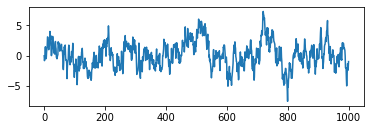

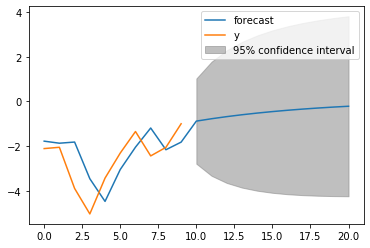

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1391.543
Method:                       css-mle   S.D. of innovations              0.972
Date:                Mon, 31 Aug 2020   AIC                           2789.085
Time:                        21:14:25   BIC                           2803.808
Sample:                             0   HQIC                          2794.681
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0875      0.279      0.314      0.754      -0.459       0.634
ar.L1.y        0.8907      0.014     62.428      0.000       0.863       0.919
                                    Roots           

NameError: name 'plot_acf' is not defined

In [6]:
# Simulating an AR Process
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np

# Plot 1: AR parameter = +0.9
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Fit an AR(1) model to the first simulated data
mod = ARMA(simulated_data_1, order=(1, 0))
res = mod.fit()
res.plot_predict(start=990, end=1010)
plt.show()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print("When the true phi=0.9, the estimate of phi (and the constant) are:")
print(res.params)

# Plot ACF

# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20)
plt.show()

# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20)
plt.show()

## Estimate Order of Model: Information Criteria

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. You will take the AR(2) simulated data from the last exercise, saved as simulated_data_2, and compute the BIC as you vary the order, p, in an AR(p) from 0 to 6.

In [ ]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(simulated_data_2, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

## <a id='2.5'>2.5 MR Model</a>

* MR Model: R = μ + φ $ε_{t}$ + θ $ε_{t-1}$
<br> Negative θ: One-Period Mean Reversion
<br> Positive θ: One-Period Momentum
<br> Note: One-period autocorrelation is θ/(1 + $θ^{2}$), not θ

An autoregression of the residual error time series is called a Moving Average (MA) model. This is confusing because it has nothing to do with the moving average smoothing process. Think of it as the sibling to the autoregressive (AR) process, except on lagged residual error rather than lagged raw observations.

Unlike an AR(1), an MA(1) model has no autocorrelation beyond lag 1, an MA(2) model has no autocorrelation beyond lag 2, etc. The lag-1 autocorrelation for an MA(1) model is not θ, but rather θ/(1 + $θ^{2}$). For example, if the MA parameter, θ, is = +0.9, the first-lag autocorrelation will be 0.9/(1 + $(0.9)^{2}$)=0.497.

<img src="MR Autocorrelation.png" width="600">

In [ ]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Forecast the first MA(1) model
mod = ARMA(simulated_data_1, order=(0,1))
res = mod.fit()
res.plot_predict(start=990, end=1010)
plt.show()

In [42]:
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__) # scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)


scipy: 1.4.1
numpy: 1.18.1
matplotlib: 3.1.3
pandas: 1.0.1
statsmodels: 0.11.0
sklearn: 0.22.1


# Evaluate Model

In [18]:
# Forecast Error
expected = np.array([0.0, 0.5, 0.0, 0.5, 0.0])
predictions = np.array([0.2, 0.4, 0.1, 0.6, 0.2])
forecast_errors = expected - predictions

# Mean Forecast Error (Forecast)
bias = np.mean(forecast_errors)

# Mean Absolute Error
mae = mean_absolute_error(expected, predictions)

# Mean Squared Error
mse = mean_squared_error(expected, predictions)

# Root Mean Squared Error
rmse = np.sqrt(mse)
rmse

0.14832396974191325

# <a id='3'>3. Machine Learning with Time Series</a>
## <a id='3.1'>3.1 Feature Generation</a>

In [ ]:
from cesium import featurize as ft
features_to_use = ["amplitude", "percent_beyond_1_std", "percent_close_to_median", "skew", "max_slope"]
fset_cesium = ft.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler = None)